# Libraries

In [1]:
import csv
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches

# Data

In [2]:
X = np.array(pd.read_csv('logistic.csv', dtype='float', ))
X = np.delete(X,[2],1)
ones = np.ones((100,1))
X = np.hstack((ones,X))
y = np.array(pd.read_csv('logistic.csv', dtype='float', ))
y = np.delete(y,[0,1],1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5) 

Visualizing the data

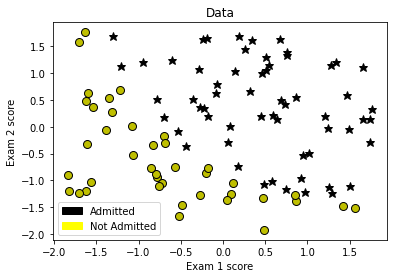

In [3]:
plt.title('Data')
for i in range(np.size(X,0)-1):
	if y[i,0] == 0:
		black_star = plt.plot(X[i,1],X[i,2], 'yo', mfc='y', ms=8, mec='k', mew=1)
	else:
		plt.plot(X[i,1],X[i,2], 'k*', lw=2, ms=9)
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')		
black_star = mpatches.Patch(color='black', label='Admitted')
yellow_dot = mpatches.Patch(color='yellow', label='Not Admitted')
plt.legend(handles=[black_star,yellow_dot])
plt.grid
plt.show()


The data has been scaled according to the StandardScaler function from sklearn.

# Defining the functions

First let's define the probability of a pair $({x}_1,{x}_2)$ to be classified as 0 by our function, i.e., $Pr(G = 0|X = x)$.

In [4]:
def probability_k1(row,parameters):
	result = np.exp(row @ parameters)/(1 + np.exp(row @ parameters))
	return result 

Now let's define the probability vector.

In [5]:
def probability_vector(dataset,parameters):
	p = np.zeros((np.size(dataset,0),1))
	for i in range(np.size(dataset,0)):
		p[i] = probability_k1(dataset[i,:],parameters)
	return p 

Now lets define the diagonal matrix of weights $W$, that consists of a matrix with: $W(i,i) = Pr(G = 0|X = {x}_i) \times (1 - Pr(G = 0|X = {x}_i))$

In [6]:
def weight_matrix(dataset,parameters):
	w = np.eye((np.size(dataset,0)))
	for i in range(np.size(dataset,0)):
		w[i,i] = probability_k1(dataset[i,:],parameters) * (1 - probability_k1(dataset[i,:],parameters))
	return w 

As an error control, lets define the misclassification rate of the algorithm

In [7]:
def misclassification(prediction,y):
	p = np.round(prediction)
	counter = 0
	for i in range(np.size(prediction,0)):
		if np.absolute(p[i] - y[i]) == 0:
			counter = counter 
		else:
			counter += 1
	return counter 

# Iteratively Reweighted Least Squares(IRLS)

Finally, lets define the IRLS algorithm to find the optimal set of parameters.
The algorithm updates the parameter beta according to the following:
$B^{new} =(X^T W X)^{-1} X^T W z$, where $z = X B^{old} + W^{-1} (y - p)$

In [8]:
def newton_step(dataset,y,n_iter):
	theta = np.zeros((np.size(dataset,1),1))
	for i in range(n_iter):
		z = dataset @ theta + np.linalg.pinv(weight_matrix(dataset,theta)) @ (y - probability_vector(dataset,theta))
		theta = np.linalg.pinv(dataset.T @ weight_matrix(dataset,theta) @ dataset) @ dataset.T @ weight_matrix(dataset,theta) @ z 
	return theta 

In [9]:
beta = newton_step(X_train,Y_train,1000)
prediction1 = probability_vector(X_train,beta)
prediction2 = probability_vector(X_test,beta)
print(f"The number of misclassifications within the training set is: {misclassification(prediction1,Y_train)}")
print(f"That gives us an aproximate correct answer rate of: {np.round((np.size(Y_train,0) - misclassification(prediction1,Y_train))/np.size(Y_train,0),2) * 100}% ")
print(f"The number of misclassifications within the test set is: {misclassification(prediction2,Y_test)}")
print(f"That gives us an aproximate correct answer rate of: {np.round((np.size(Y_test,0) - misclassification(prediction2,Y_test))/np.size(Y_test,0),2) * 100}% ")

The number of misclassifications within the training set is: 12
That gives us an aproximate correct answer rate of: 85.0% 
The number of misclassifications within the test set is: 2
That gives us an aproximate correct answer rate of: 90.0% 


# Visualizing the decision boundary

To find the decidion boundary we must solve the following: ${B}_0 + {B}_1 {x}_1 + {B}_2 {x}_2 = 0 \therefore {x}_2 = \frac{-{B}_1 {x}_1 - {B}_0}{{B}_2}$

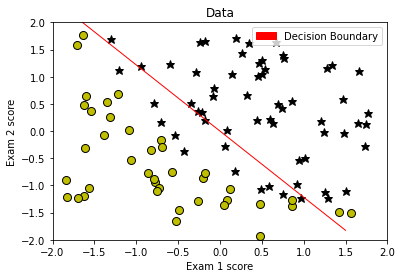

In [10]:
plt.title('Data')
for i in range(np.size(X,0)):
	if y[i,0] == 0:
		black_star = plt.plot(X[i,1],X[i,2], 'yo', mfc='y', ms=8, mec='k', mew=1)
	else:
		plt.plot(X[i,1],X[i,2], 'k*', lw=2, ms=9)
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')		
plt.xlim(-2,2)
plt.ylim(-2,2)
x1 = np.arange(-2,2,0.5)
x2 = ((-1 * beta[1] * x1) - beta[0])/beta[2]
plt.plot(x1,x2,'r',lw=1)
decision_boundary = mpatches.Patch(color='red', label='Decision Boundary')
plt.legend(handles=[decision_boundary], loc='upper right')
plt.grid
plt.show()